In [ ]:
import pandas as pd
import numpy as np

In [ ]:
customer = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_customers_dataset.csv')
geo = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_geolocation_dataset.csv')
item = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_order_items_dataset.csv')
payment = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_order_payments_dataset.csv')
review = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_order_reviews_dataset.csv')
order = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_orders_dataset.csv')
product_list = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_products_dataset.csv')
seller = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_sellers_dataset.csv')
product_category = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\product_category_name_translation.csv')
MQL = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_marketing_qualified_leads_dataset.csv')
closed_deals = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_closed_deals_dataset.csv')

In [ ]:
list_of_df = [customer,
              geo,
              item,
              payment,
              review,
              order,
              product_list,
              seller,
              product_category,
              closed_deals,
              MQL]

for df in list_of_df:
    print(list(df.columns), len(df.columns))

# 1. RFM ANALYSIS

## 1.1. RECENCY

In [ ]:
# getting the latest day of purchase for each user
recency_table = customer.merge(order, on ="customer_id")
recency_table = recency_table.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'}).reset_index()
# convert to datetime dtype
recency_table['order_purchase_timestamp'] = pd.to_datetime(recency_table['order_purchase_timestamp'])
# calculate the current day 
current_day = pd.to_datetime(max(order['order_purchase_timestamp']))
# calculate the days between
recency_table['days_between'] = (current_day - recency_table['order_purchase_timestamp']).apply(lambda x: int(str(x).split()[0]))
# def function that scores the data
def scoring(x):
    # calculate quantiles
    quan_val_list = []
    for quan in [0.2,0.4,0.6,0.8]:
        quan_val_list.append(np.quantile(x,quan))
    # label the data base on the quantile value
    def labeling(x):
        if x < quan_val_list[0]: return 1
        elif x < quan_val_list[1]: return 2
        elif x < quan_val_list[2]: return 3
        elif x < quan_val_list[3]: return 4
        else: return 5

    return x.apply(labeling)

recency_table['recency_score'] = scoring(recency_table['days_between'])

## 1.2. FREQUENCY

In [ ]:
# merging df
frequency_table = customer.merge(order, on="customer_id")
# getting interested information
frequency_table = frequency_table.groupby('customer_unique_id').agg({
    "order_purchase_timestamp": ['min', 'max'],
    "order_id": 'count'
}).reset_index()
# change columns
frequency_table.columns = ['customer_unique_id', 'min', 'max', 'count']
# change data type
frequency_table['max'] = pd.to_datetime(frequency_table['max'])
frequency_table['min'] = pd.to_datetime(frequency_table['min'])
# days between first and last day of purchase 
frequency_table['days_between'] = (frequency_table['max'] - frequency_table['min']).apply(lambda x: int(str(x).split()[0]))
frequency_table['days_between'].value_counts()
# get rid of one-time-purchase customer
frequency_table = frequency_table[frequency_table['days_between']>0]
# calculate purchase_rate
frequency_table['purchase_rate'] = frequency_table['count'] / frequency_table['days_between']
# score the purchase_rate
frequency_table['frequency_score'] = scoring(frequency_table['purchase_rate'])

## 1.3. MONETARY

In [ ]:
monetary_table = payment.merge(order, on="order_id").merge(customer, on="customer_id")
monetary_table = monetary_table.groupby('customer_unique_id').agg({'payment_value':'sum'}).reset_index()
monetary_table['monetary_score'] = scoring(monetary_table['payment_value'])
monetary_table

## 1.4 COMBINE ALL TOGETHER

In [ ]:
final_table = recency_table.merge(monetary_table, on = 'customer_unique_id').merge(frequency_table, on='customer_unique_id')

In [ ]:
final_table = final_table[['customer_unique_id', "recency_score", "frequency_score","monetary_score"]]

In [ ]:
final_table['frequency_monetary_score'] = scoring(final_table['frequency_score'] + final_table['monetary_score'])

In [ ]:
final_table = final_table[['customer_unique_id', 'recency_score', 'frequency_monetary_score']]

In [51]:
segment_dict = {# hibernating
(1,1):"hibernating",
(1,2):"hibernating",
(2,1):"hibernating",
(2,2):"hibernating",
# about to sleep
(3,1):"about to sleep",
(3,2):"about to sleep",
# promising
(4,1):"promising",
# new customer
(5,1):"new customer",
# potential customers
(4,2):"potential",
(4,3):"potential",
(5,2):"potential",
(5,3):"potential",
# need attion
(3,3):"need attion",
# at risk
(1,3):"at risk",
(1,4):"at risk",
(2,3):"at risk",
(2,4):"at risk",
# do not lose
(1,5):"do not lose",
(2,5):"do not lose",
# loyal customer
(3,4):"loyal",
(3,5):"loyal",
(4,4):"loyal",
(4,5):"loyal",
# champions
(5,4):"champions",
(5,5):"champions"}

In [53]:
final_table['segment'] = final_table.apply(lambda x:
                  segment_dict[(x['recency_score'],x['frequency_monetary_score'])]
                  , axis = 1
                  )

C:\Users\Admin\AppData\Local\Temp\ipykernel_19196\1553612272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table['segment'] = final_table.apply(lambda x:


In [58]:
final_data = final_table['segment'].value_counts()

<BarContainer object of 10 artists>

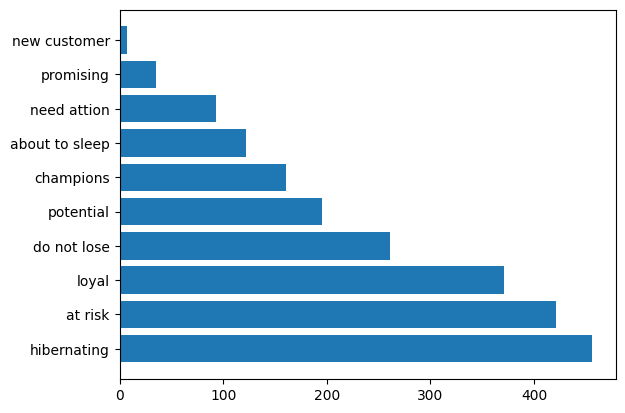

In [59]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.barh(
    y =  final_data.index, 
    width =  final_data.values
)